In [49]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scipy.cluster.hierarchy as sch
from scipy.stats import pearsonr
import seaborn as sns

from pathlib import Path
from scipy.spatial.distance import squareform
from typing import Mapping, Optional, Sequence, Tuple

In [4]:
project_dir = Path(os.environ["UNSUPERVISED_AGING"])
data_dir = project_dir / "data"

In [12]:
kpmsv0_unsup_features = pd.read_csv(data_dir / "2025-06-26_kpms-v0_unsupervised-features.csv")
kpmsv0_unsup_results = pd.read_csv(data_dir / "2025-06-26_kpms-v0_unsupervised-results.csv", low_memory=False)
kpmsv1_supunsup_features = pd.read_csv(data_dir / "2025-06-28_kpms-v1_supervised-unsupervised-features.csv")
kpmsv1_supunsup_results = pd.read_csv(data_dir / "2025-06-28_kpms-v1_supervised-unsupervised-results.csv", low_memory=False)

with (data_dir / "2025-06-26_kpms-v0_unsupervised-xcats.json").open("r") as f:
    kpmsv0_unsup_xcats = json.load(f)
with (data_dir / "2025-06-28_kpms-v1_supervised-unsupervised-xcats.json").open("r") as f:
    kpmsv1_supunsup_xcats = json.load(f)

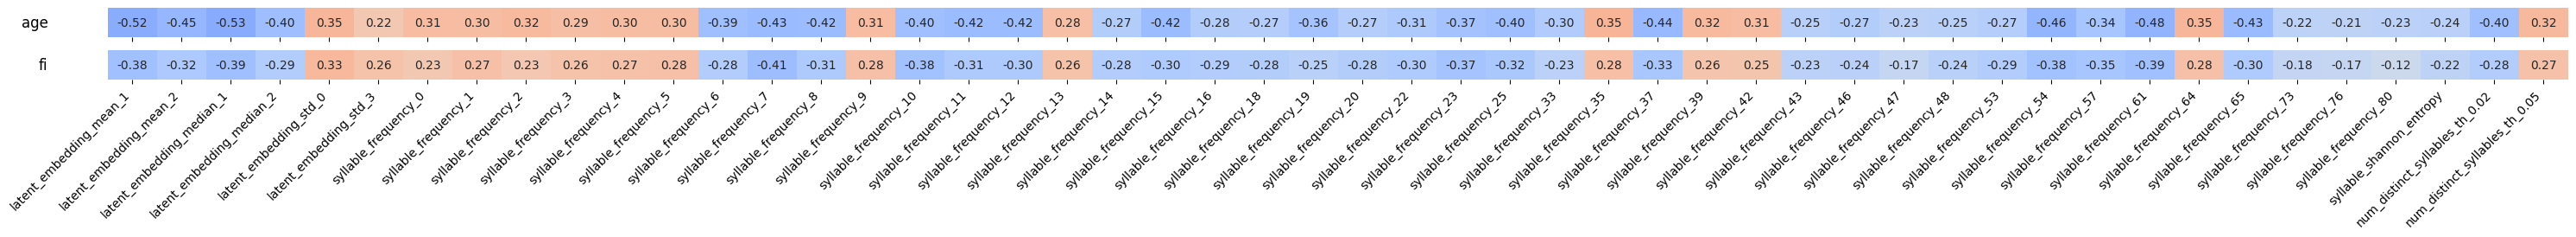

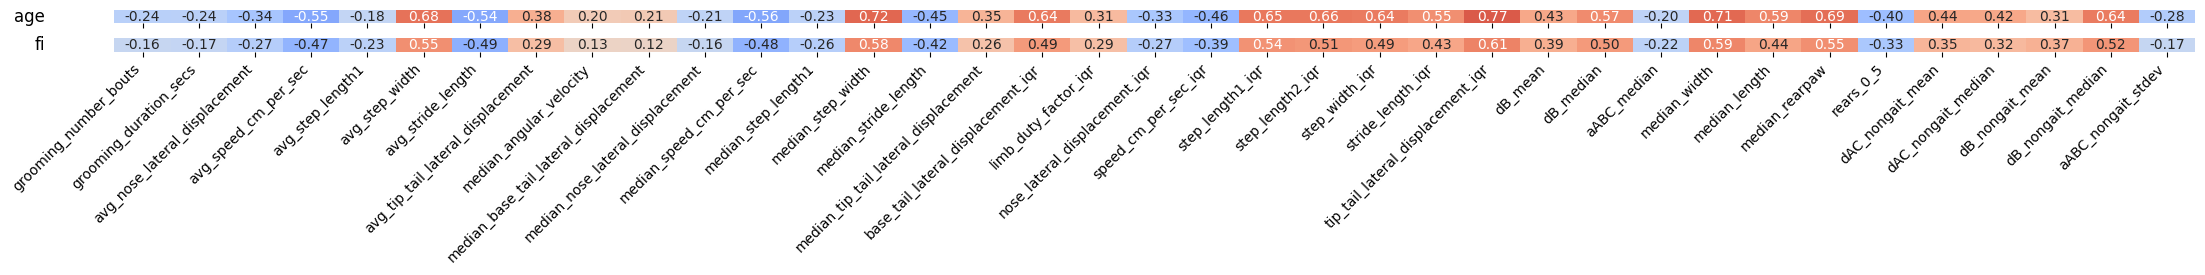

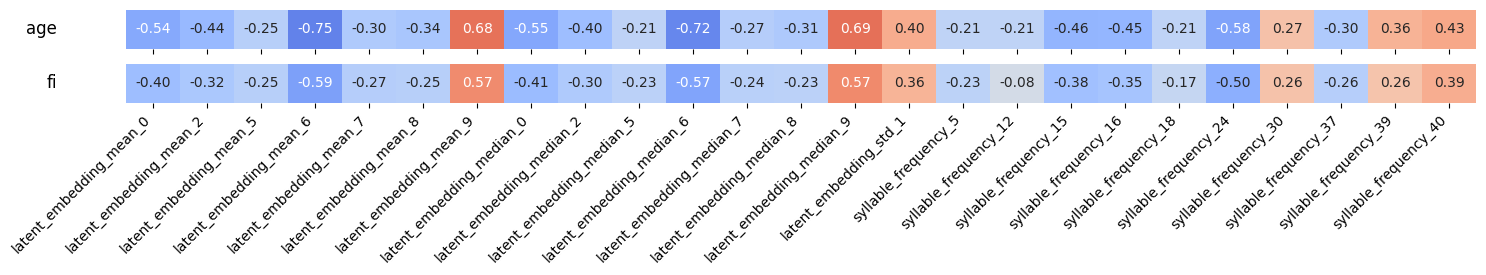

In [27]:
def plot_horizontal_heatmap(
    df: pd.DataFrame,
    *,
    targets: Sequence[str] = ["age", "fi"],
    th: float              = 0.2
):
    feature_set = [col for col in df.columns if col not in targets]
    corr_df = pd.DataFrame(
        {tgt: df[feature_set + [tgt]].corr().loc[tgt, feature_set] for tgt in targets}
    ).T
    mask = corr_df.abs().gt(th).any(axis=0)
    filtered_df = corr_df.loc[:, mask]
    if filtered_df.empty:
        raise ValueError(f"No features exceed |r| > {th:.2f}.")
    fig_h = 1.5 * len(targets)
    fig_w = 0.6 * filtered_df.shape[1]
    fig, axes = plt.subplots(len(targets), 1, figsize=(fig_w, fig_h), sharex=True)
    if len(targets) == 1:
        axes = [axes]
    for ax, tgt in zip(axes, targets):
        sns.heatmap(
            filtered_df.loc[[tgt]],
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            center=0,
            annot=True,
            fmt=".2f",
            cbar=False,
            ax=ax,
        )
        ax.set_ylabel(tgt, rotation=0, fontsize=12, ha="right", va="center", labelpad=50)
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=45)
        plt.setp(ax.get_xticklabels(), ha="right")
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

plot_horizontal_heatmap(kpmsv1_supunsup_features[["age", "fi"] + kpmsv1_supunsup_xcats["unsup"]])
plot_horizontal_heatmap(kpmsv1_supunsup_features[["age", "fi"] + kpmsv1_supunsup_xcats["sup"]])
plot_horizontal_heatmap(kpmsv0_unsup_features[["age", "fi"] + kpmsv0_unsup_xcats["no_trans_mats"]])

In [23]:
kpmsv1_unsup_labels = {
    "latent_embedding": [col for col in kpmsv1_supunsup_xcats["unsup"] if col.startswith("latent_embedding")],
    "syllable_frequency": [col for col in kpmsv1_supunsup_xcats["unsup"] if col.startswith("syllable_frequency")],
}
kpmsv1_unsup_labels["engineered"] = list(set(kpmsv1_supunsup_xcats["unsup"]) - 
                                         (set(kpmsv1_unsup_labels["latent_embedding"]) | set(kpmsv1_unsup_labels["syllable_frequency"])))

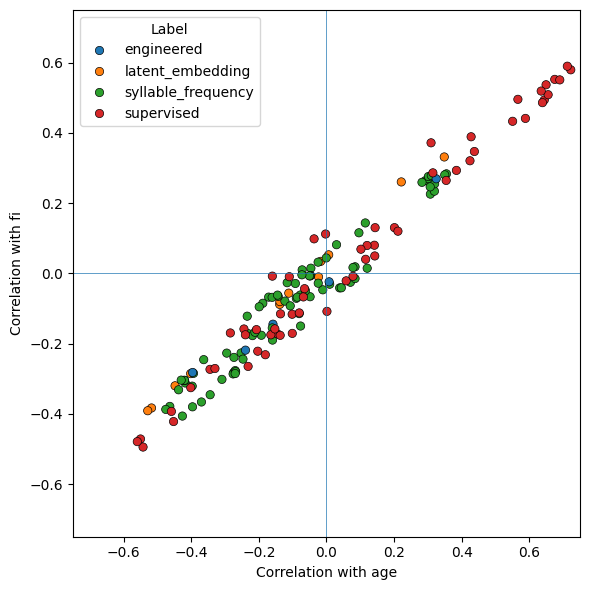

In [37]:
def plot_correlation_scatterplot(
    df: pd.DataFrame,
    labels: Mapping[str, Sequence[str]],
    *,
    targets: Sequence[str]   = ["age", "fi"],
    th: float                = 0.,
    lim: Tuple[float, float] = (-1., 1.),
):
    if len(targets) != 2:
        raise ValueError("targets must contain exactly two elements.")
    feature_set = [col for col in df.columns if col not in targets]
    corr_x = df[feature_set + [targets[0]]].corr().loc[targets[0], feature_set]
    corr_y = df[feature_set + [targets[1]]].corr().loc[targets[1], feature_set]
    corr_df = pd.DataFrame({"feature": feature_set, "x": corr_x.values, "y": corr_y.values})
    corr_df = corr_df[corr_df[["x", "y"]].abs().gt(th).any(axis=1)]
    if corr_df.empty:
        raise ValueError(f"No features exceed |r| > {th:.2f}.")
    def assign_label(col):
        for label, cols in labels.items():
            if col in cols:
                return label
        return "Other"
    corr_df["label"] = corr_df["feature"].apply(assign_label)
    unique_labels = corr_df["label"].unique()
    palette = dict(zip(unique_labels, sns.color_palette(n_colors=len(unique_labels))))
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=corr_df, x="x", y="y", hue="label", palette=palette, edgecolor="black")
    plt.axhline(0, linewidth=0.5)
    plt.axvline(0, linewidth=0.5)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.xlabel(f"Correlation with {targets[0]}")
    plt.ylabel(f"Correlation with {targets[1]}")
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()

plot_correlation_scatterplot(
    kpmsv1_supunsup_features[["age", "fi"] + kpmsv1_supunsup_xcats["unsup"] + kpmsv1_supunsup_xcats["sup"]], 
    {**kpmsv1_unsup_labels, "supervised": kpmsv1_supunsup_xcats["sup"]}, lim=(-0.75, 0.75))
# plot_correlation_scatterplot(kpmsv1_supunsup_features[["age", "fi"] + kpmsv1_supunsup_xcats["sup"]], {"supervised": kpmsv1_supunsup_xcats["sup"]})

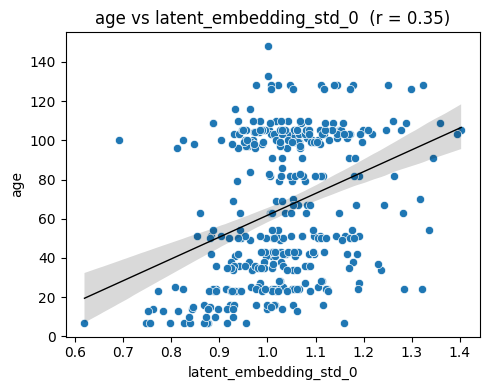

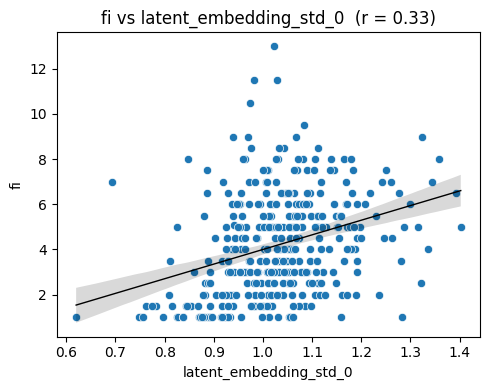

In [39]:
def plot_scatterplot_of_features(
    df: pd.DataFrame,
    x_col: str,
    y_col: str
):
    data = df[[x_col, y_col]].dropna()
    r, _ = pearsonr(data[x_col], data[y_col])
    
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=x_col, y=y_col, data=data, s=35)
    
    sns.regplot(
        x=x_col, y=y_col, data=data,
        scatter=False, line_kws={"color": "black", "linewidth": 1}
    )
    
    plt.title(f"{y_col} vs {x_col}  (r = {r:.2f})")
    plt.tight_layout()
    plt.show()

plot_scatterplot_of_features(kpmsv1_supunsup_features, "latent_embedding_std_0", "age")
plot_scatterplot_of_features(kpmsv1_supunsup_features, "latent_embedding_std_0", "fi")

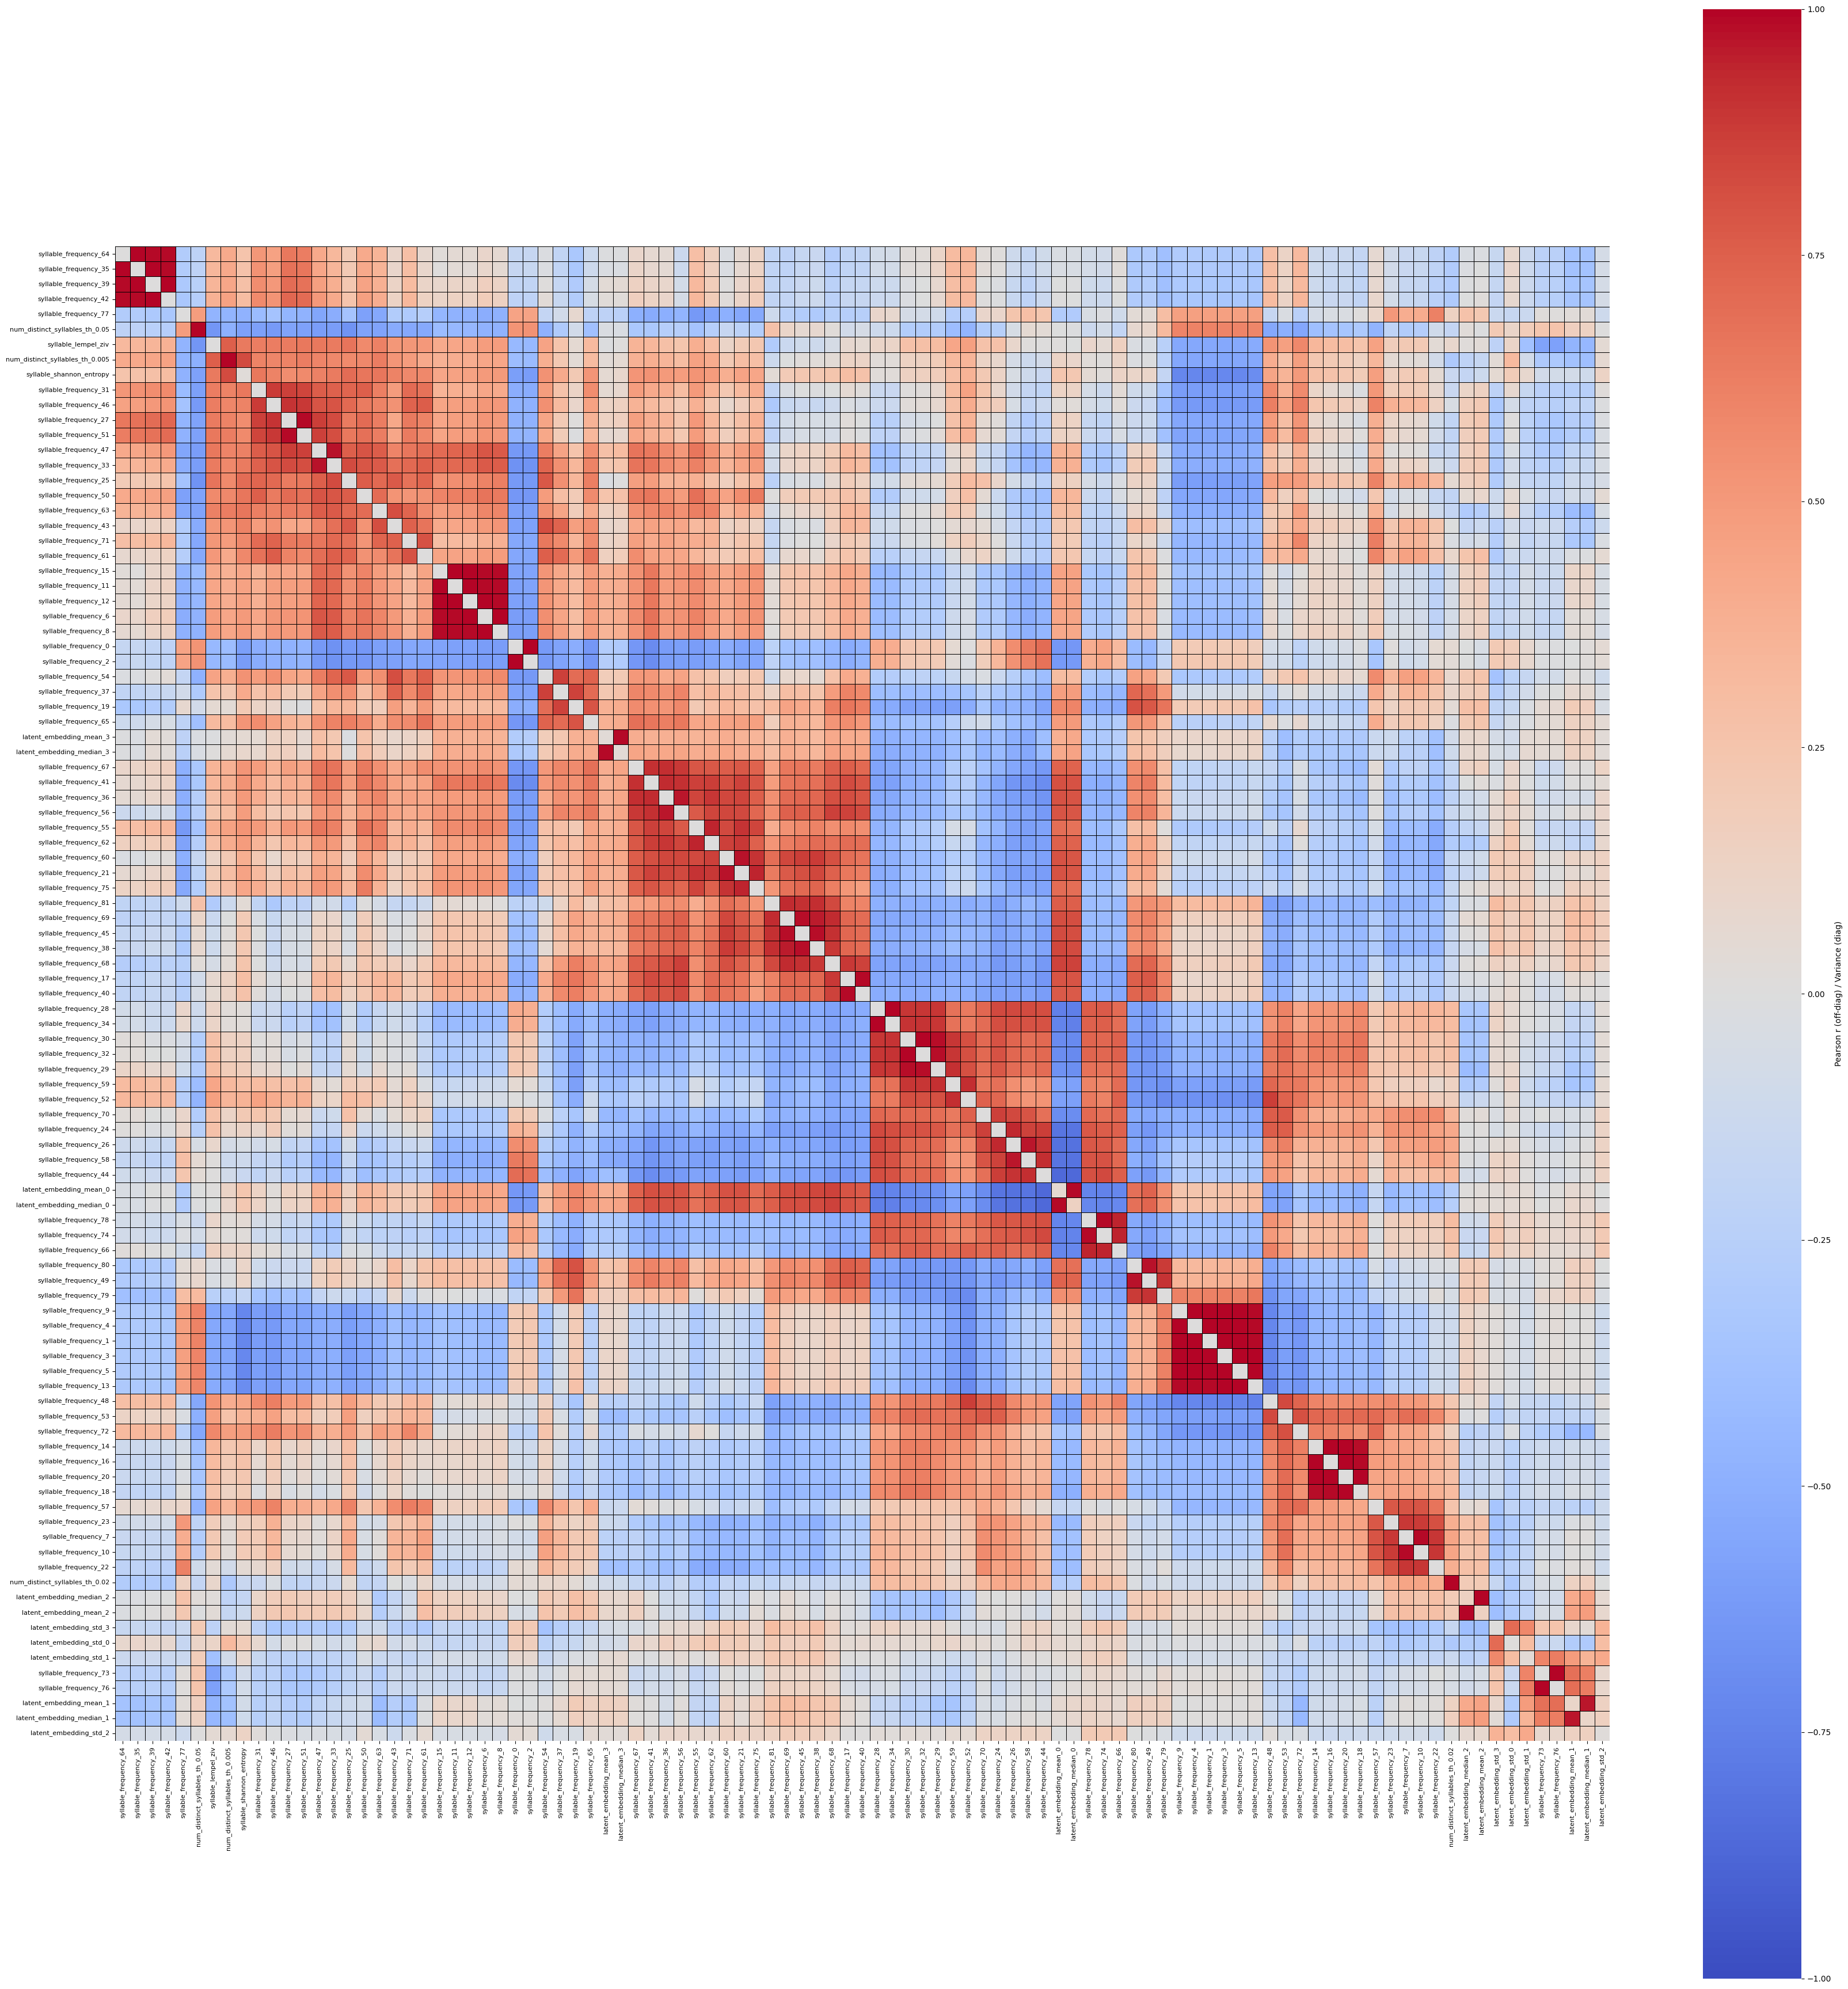

In [41]:
def plot_correlation_matrix_heatmap(
    df: pd.DataFrame,
    *,
    cluster:bool = True
):
    X = (
        df.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    )

    X = X.loc[:, X.nunique(dropna=True) > 1]
    
    if X.shape[1] < 2:
        raise ValueError("Need at least two valid features to plot a grid.")
    
    corr = X.corr(method="pearson")
    var  = X.var()
    np.fill_diagonal(corr.values, var)
    
    if cluster:
        dist_for_linkage = 1 - corr.abs().fillna(0).values
        linkage = sch.linkage(
            squareform(dist_for_linkage, checks=False),
            method="average",
            optimal_ordering=True,
        )
        order = sch.dendrogram(linkage, no_plot=True)["leaves"]
        corr  = corr.iloc[order, order]
    
    n = len(corr)
    fig_size = max(4, n * 0.35)
    plt.figure(figsize=(fig_size, fig_size))
    
    sns.heatmap(
        corr,
        cmap="coolwarm",
        center=0,
        vmin=-1, vmax=1,
        linewidths=0.4,
        linecolor="black",
        square=True,
        cbar_kws={"label": "Pearson r (off-diag) / Variance (diag)"},
    )
    
    plt.xticks(rotation=90, ha="center", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix_heatmap(kpmsv1_supunsup_features[kpmsv1_supunsup_xcats["unsup"]])

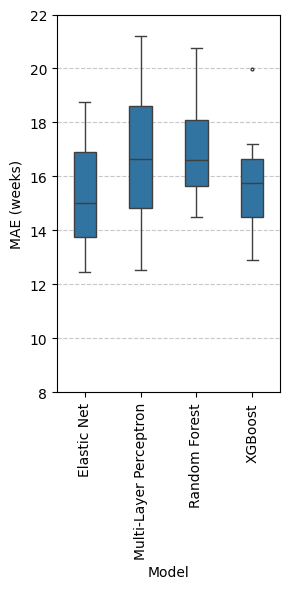

In [51]:
def plot_model_performance_bar_graph(
    df: pd.DataFrame,
    *,
    figsize: Tuple[float, float]       = (3., 6.),
    lim: Optional[Tuple[float, float]] = None,
    ylabel: str                        = "MAE",
):
    abs_err = (df["y_pred"] - df["y_true"]).abs()
    fold_mae = (
        abs_err.groupby([df["model"], df["fold"]])
        .mean()
        .reset_index(name="mae")
    )

    assert fold_mae.groupby("model").size().eq(10).all(), "Some model is missing folds."

    plt.figure(figsize=figsize)
    sns.boxplot(
        x="model",
        y="mae",
        data=fold_mae,
        showfliers=True,
        width=0.4,
        flierprops={"marker": ".", "color": "black", "markersize": 4},
    )
    plt.xticks(rotation=90)
    if lim:
        plt.ylim(*lim)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xlabel("Model")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

plot_model_performance_bar_graph(
    kpmsv1_supunsup_results[
        (kpmsv1_supunsup_results["y_cat"] == "age") &
        (kpmsv1_supunsup_results["X_cat"] == "unsup") &
        (kpmsv1_supunsup_results["split"]  == "test") &
        (kpmsv1_supunsup_results["model"].isin(["Elastic Net", "Random Forest", "XGBoost", "Multi-Layer Perceptron"]))
    ],
    lim = (8., 22.),
    ylabel = "MAE (weeks)",
)

In [63]:
def plot_grouped_model_performance_bar_graph(
    dfs: Sequence[pd.DataFrame],
    label_map: Optional[Mapping[str, str]] = None,
    *,
    figsize: Tuple[float, float]       = (6.0, 6.0),
    lim: Optional[Tuple[float, float]] = None,
    ylabel: str                        = "MAE",
) -> None:
    frames = []
    for df in dfs:
        mae = (df["y_pred"] - df["y_true"]).abs()
        frame = (
            mae.groupby([df["model"], df["fold"]])
            .mean()
            .reset_index(name="mae")
        )
        frame["X_cat"] = df["X_cat"].iloc[0]
        frames.append(frame)

    fold_mae_all = pd.concat(frames, ignore_index=True)
    fold_mae_all["slice_label"] = (
        fold_mae_all["X_cat"].map(label_map) if label_map else fold_mae_all["X_cat"]
    )

    assert fold_mae_all.groupby(["model", "X_cat"]).size().eq(10).all(), "Some model is missing folds."

    plt.figure(figsize=figsize)
    sns.boxplot(
        data=fold_mae_all,
        x="model",
        y="mae",
        hue="slice_label",
        dodge=True,
        width=0.6,
        showfliers=True,
        flierprops={"marker": ".", "markersize": 4, "color": "black"},
    )
    plt.xticks(rotation=90)
    if lim:
        plt.ylim(*lim)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xlabel("Model")
    plt.ylabel(ylabel)
    plt.legend(title=None, loc="upper right")
    plt.tight_layout()
    plt.show()

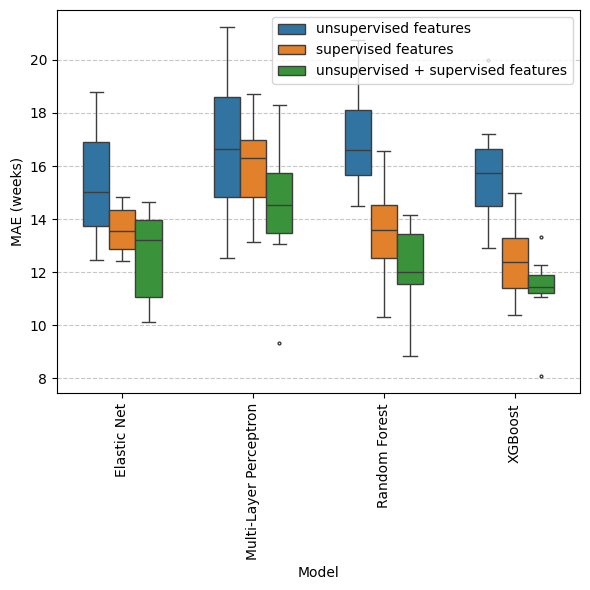

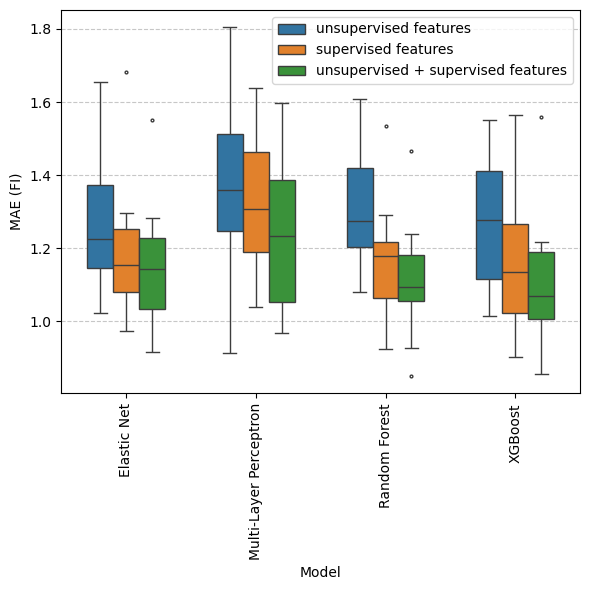

In [66]:
def plot_ycat_kpmsv1_supunsup_results(ycat: str, ylabel: str):
    plot_grouped_model_performance_bar_graph(
        [
            kpmsv1_supunsup_results[
                (kpmsv1_supunsup_results["y_cat"] == ycat) &
                (kpmsv1_supunsup_results["X_cat"] == "unsup") &
                (kpmsv1_supunsup_results["split"]  == "test") &
                (kpmsv1_supunsup_results["model"].isin(["Elastic Net", "Random Forest", "XGBoost", "Multi-Layer Perceptron"]))
            ],
            kpmsv1_supunsup_results[
                (kpmsv1_supunsup_results["y_cat"] == ycat) &
                (kpmsv1_supunsup_results["X_cat"] == "sup") &
                (kpmsv1_supunsup_results["split"]  == "test") &
                (kpmsv1_supunsup_results["model"].isin(["Elastic Net", "Random Forest", "XGBoost", "Multi-Layer Perceptron"]))
            ],
            kpmsv1_supunsup_results[
                (kpmsv1_supunsup_results["y_cat"] == ycat) &
                (kpmsv1_supunsup_results["X_cat"] == "all") &
                (kpmsv1_supunsup_results["split"]  == "test") &
                (kpmsv1_supunsup_results["model"].isin(["Elastic Net", "Random Forest", "XGBoost", "Multi-Layer Perceptron"]))
            ],
        ],
        {
            "unsup": "unsupervised features",
            "sup": "supervised features",
            "all": "unsupervised + supervised features",
        },
        ylabel=ylabel,
    )

plot_ycat_kpmsv1_supunsup_results("age", ylabel="MAE (weeks)")
plot_ycat_kpmsv1_supunsup_results("fi", ylabel="MAE (FI)")

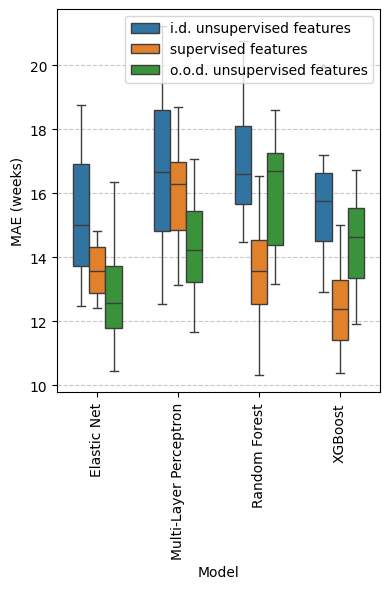

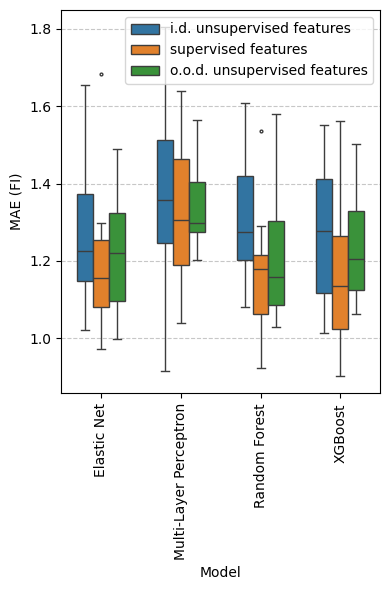

In [72]:
def plot_ycat_kpmsv0_kpmsv1_results(ycat: str, ylabel: str):
    plot_grouped_model_performance_bar_graph(
        [
            kpmsv1_supunsup_results[
                (kpmsv1_supunsup_results["y_cat"] == ycat) &
                (kpmsv1_supunsup_results["X_cat"] == "unsup") &
                (kpmsv1_supunsup_results["split"]  == "test") &
                (kpmsv1_supunsup_results["model"].isin(["Elastic Net", "Random Forest", "XGBoost", "Multi-Layer Perceptron"]))
            ],
            kpmsv1_supunsup_results[
                (kpmsv1_supunsup_results["y_cat"] == ycat) &
                (kpmsv1_supunsup_results["X_cat"] == "sup") &
                (kpmsv1_supunsup_results["split"]  == "test") &
                (kpmsv1_supunsup_results["model"].isin(["Elastic Net", "Random Forest", "XGBoost", "Multi-Layer Perceptron"]))
            ],
            # kpmsv1_supunsup_results[
            #     (kpmsv1_supunsup_results["y_cat"] == ycat) &
            #     (kpmsv1_supunsup_results["X_cat"] == "all") &
            #     (kpmsv1_supunsup_results["split"]  == "test") &
            #     (kpmsv1_supunsup_results["model"].isin(["Elastic Net", "Random Forest", "XGBoost", "Multi-Layer Perceptron"]))
            # ],
            kpmsv0_unsup_results[
                (kpmsv0_unsup_results["y_cat"] == ycat) & 
                (kpmsv0_unsup_results["X_cat"] == "no_trans_mats") & 
                (kpmsv0_unsup_results["split"] == "test") & 
                (kpmsv0_unsup_results["model"].isin(["Elastic Net", "Random Forest", "XGBoost", "Multi-Layer Perceptron"]))
            ],
        ],
        {
            "unsup": "i.d. unsupervised features",
            "sup": "supervised features",
            # "all": "unsupervised + supervised features",
            "no_trans_mats": "o.o.d. unsupervised features",
        },
        ylabel=ylabel,
        figsize=(4., 6.),
    )

plot_ycat_kpmsv0_kpmsv1_results("age", ylabel="MAE (weeks)")
plot_ycat_kpmsv0_kpmsv1_results("fi", ylabel="MAE (FI)")

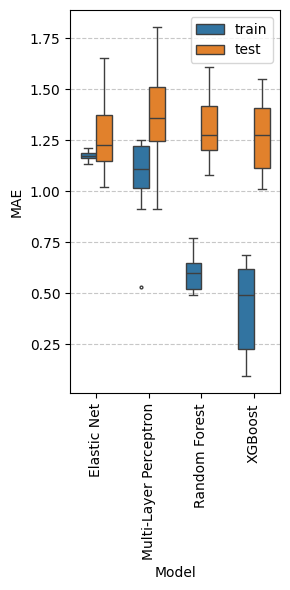

In [77]:
def plot_split_model_performance_bar_graph(
    df: pd.DataFrame,
    *,
    splits: Sequence[str]               = ("train", "test"),
    figsize: Tuple[float, float]        = (6.0, 6.0),
    lim: Optional[Tuple[float, float]]  = None,
    ylabel: str                         = "MAE",
) -> None:
    frames = []
    for split_val in splits:
        subset = df[df["split"] == split_val]
        mae = (subset["y_pred"] - subset["y_true"]).abs()
        frame = (
            mae.groupby([subset["model"], subset["fold"]])
            .mean()
            .reset_index(name="mae")
        )
        frame["split_label"] = split_val
        frames.append(frame)

    fold_mae_all = pd.concat(frames, ignore_index=True)

    assert (
        fold_mae_all.groupby(["model", "split_label"]).size().eq(10).all()
    ), "Some model is missing folds."

    plt.figure(figsize=figsize)
    sns.boxplot(
        data=fold_mae_all,
        x="model",
        y="mae",
        hue="split_label",
        dodge=True,
        width=0.6,
        showfliers=True,
        flierprops={"marker": ".", "markersize": 4, "color": "black"},
    )
    plt.xticks(rotation=90)
    if lim:
        plt.ylim(*lim)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xlabel("Model")
    plt.ylabel(ylabel)
    plt.legend(title=None, loc="upper right")
    plt.tight_layout()
    plt.show()

plot_split_model_performance_bar_graph(
    kpmsv1_supunsup_results[
        (kpmsv1_supunsup_results["y_cat"] == "fi") &
        (kpmsv1_supunsup_results["X_cat"] == "unsup") &
        (kpmsv1_supunsup_results["model"].isin(["Elastic Net", "Random Forest", "XGBoost", "Multi-Layer Perceptron"]))
    ],
    figsize=(3, 6),
)